### Import Packages

In [59]:
import numpy as np
import pandas as pd
import torch

from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier, plot_importance
from skorch import NeuralNetClassifier

from NN_model import NeuralNet

### Import Data

In [60]:
X_train_bal = pd.read_csv("processed_data/X_train_bal.csv")
X_test_bal = pd.read_csv("processed_data/X_test_bal.csv")

y_train_bal = pd.read_csv("processed_data/y_train_bal.csv")
y_test_bal = pd.read_csv("processed_data/y_test_bal.csv")

### Training Models
We first define a collection of models to train and evaluate from the prepared data:

In [61]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Decision Trees": DecisionTreeClassifier(),
    "Adaboost": AdaBoostClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boost": XGBClassifier(),
    # "MLP Classifier": NeuralNetClassifier(NeuralNet, max_epochs=20, lr=0.001, batch_size=10, iterator_train__shuffle=True, verbose=0, optimizer=torch.optim.Adam)
}

In [62]:
scores = {
    "Training Scores": [],
    "Testing Scores": [],
    "Precision": [],
    "Recall": [],
    "F-score": []
}

for label, model in models.items():
    model.fit(X_train_bal, y_train_bal.values.ravel())
    training_score = model.score(X_train_bal, y_train_bal)
    testing_score = model.score(X_test_bal, y_test_bal)
    y_pred = model.predict(X_test_bal)
    
    precision, recall, f_score, support = precision_recall_fscore_support(y_test_bal, y_pred, average="binary", pos_label=1)

    scores["Training Scores"].append(training_score)
    scores["Testing Scores"].append(testing_score)
    scores["Precision"].append(precision)
    scores["Recall"].append(recall)
    scores["F-score"].append(f_score)

df = pd.DataFrame(scores, index=models.keys()).sort_values("F-score", ascending=False)
df

,Training Scores,Testing Scores,Precision,Recall,F-score
Gradient Boost,0.996523,0.930771,0.995967,0.865044,0.925900
Adaboost,0.825997,0.823424,0.857390,0.775903,0.814614
Decision Trees,0.997570,0.834762,0.989883,0.676438,0.803680
Random Forest,0.997570,0.823055,0.994776,0.649521,0.785902
Logistic Regression,0.608804,0.558444,0.563950,0.515395,0.538580
Naive Bayes,0.581163,0.555079,0.559984,0.514196,0.536114


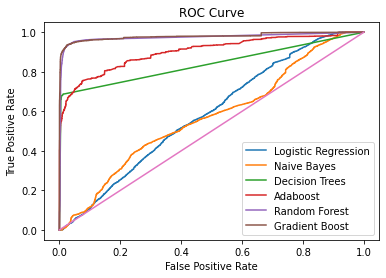

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

for label, model in models.items():
    model.fit(X_train_bal, y_train_bal.values.ravel())
    y_score = model.predict_proba(X_test_bal)[:,1]
    fpr, tpr, thres = roc_curve(y_test_bal, y_score)
    plt.plot(fpr, tpr)

plt.legend(models.keys())
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot([0, 1], [0,1])

plt.show()


It is clear that gradient boost has the best performance in terms of testing score, f-score while having similar ROC curve with Random Forest.

### Feature Importance

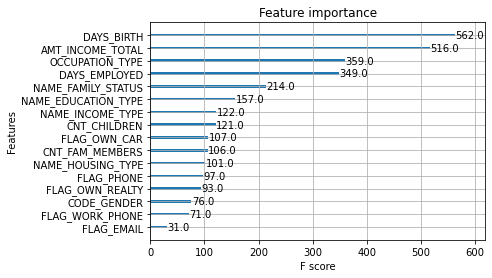

In [64]:
ax = plot_importance(model)

From the above figure, it can be seen that several features including `DAYS_BIRTH`, `AMT_INCOME_TOTAL`, `OCCUPATION_TYPE`, `DAYS_EMPLOYED` etc. bear much higher importance than the others.

This implies that it is possible to use fewer features to train and predict the approval decision, even though XGBoost Classifier has built-in feature selection.

In [65]:
# Saving the XGBClassifier model
xgb_model = models["Gradient Boost"]
xgb_model.save_model("xgb_model.json")